In [9]:
from helpers import *
import numpy as np
import copy
import matplotlib.pyplot as plt
from NLLinkNet.loss import *
from NLLinkNet.networks.dinknet import *
from NLLinkNet.networks.unet import *
from NLLinkNet.networks.nllinknet_pairwise_func import *
from Loader import *
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler
from postprocessing import *
import time
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import f1_score


## 1) Training

In [12]:
def train(batch_size=8, epochs=50, lr=1e-4):
    ## Define device for training
    device = torch.device("mps" )
    print("Using device: {}".format(device))
    current_time = time.strftime("%Y_%m_%d_%H:%M:%S")
    savepath = "models/"+str(current_time)+".pt"
    ########################################################################################################################################
    ## Create dataset
    transform = transforms.Compose([transforms.ToTensor(), ]) # Convert PIL Images to tensors # Add any other transforms you need here
    dataset = SatelliteDataset("data/training/images", "data/training/groundtruth", transform=transform)
    
    
    nb_mit_samples = 1 ## TODO: Set number of samples to use for MIT dataset
    dataset_mit = SatelliteDataset("data/MIT/training/images", "data/MIT/training/groundtruth", transform=transform)
    dataset_mit = torch.utils.data.Subset(dataset_mit, range(nb_mit_samples))
    
    
    ########################################################################################################################################
    ## Splitting dataset into train and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, dataset_mit])
    print("Training set size: {}".format(len(train_dataset)))

    ########################################################################################################################################
    ## Create DataLoaders for train and validation sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    
    ########################################################################################################################################
    ## Create model
    # model = DinkNet34(num_classes=1).to(device)
    # model = LinkNet34(num_classes=1).to(device)
    # model = Baseline(num_classes=1).to(device)
    # model = NL3_LinkNet(num_classes=1).to(device)
    # model = NL34_LinkNet(num_classes=1).to(device)
    model = NL_LinkNet_EGaussian(num_classes=1).to(device)
    # model = NL_LinkNet_Gaussian(num_classes=1).to(device)
    
    
    ########################################################################################################################################
    #Optimoizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
    # scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)
    calc_loss = dice_bce_loss()

    ########################################################################################################################################
    best_loss = 1e10
    best_f1_score = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    train_losses = []
    val_losses = []
    # Add variables to store all labels and predictions for F1 calculation
    val_labels_all, val_preds_all = [], []
    for epoch in tqdm(range(epochs),desc="Training"):
        print('-' * 100,'Epoch {}/{}\n'.format(epoch, epochs - 1))
        since = time.time()
        ########################################################################################################################################
        # Training phase
        model.train()
        train_loss = 0.0
        train_samples = 0

        for inputs, labels in tqdm(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            #Models expect input images to be divisible by 32 so we pad the input images
            inputs = F.pad(inputs, (8, 8, 8, 8))  # Pad inputs
            labels = F.pad(labels, (8, 8, 8, 8))  # Crop labels
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)  # Pad inputs
                loss = calc_loss(outputs, labels)  # Crop labels
                loss.backward()
                optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_samples += inputs.size(0)

        train_epoch_loss = train_loss / train_samples
        train_losses.append(train_epoch_loss)
        print("Training Loss: {:.4f}".format(train_epoch_loss))

        ########################################################################################################################################
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_samples = 0

        for inputs, labels in val_dataloader:
            inputs = F.pad(inputs, (8, 8, 8, 8),value=0)  # Pad inputs
            labels = F.pad(labels, (8, 8, 8, 8),value=0)  # Crop labels
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels > 0.5
            labels = labels.float()
            
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = calc_loss(outputs, labels)

        val_loss += loss.item() * inputs.size(0)
        val_samples += inputs.size(0)
        # Store predictions and labels
        preds = (outputs > 0.5).view(-1).cpu().numpy()  # Flatten and threshold predictions
        labels_flat = labels.view(-1).cpu().numpy()  # Flatten labels
        val_f1_score = f1_score(labels_flat, preds, average='binary')
        print("IoU score: {:.4f}".format(IoU(preds,labels_flat)))
        print("F1 score: {:.4f}".format(val_f1_score))

        val_labels_all.extend(labels_flat)
        val_preds_all.extend(preds)

        scheduler.step()
        val_epoch_loss = val_loss / val_samples
        val_losses.append(val_epoch_loss)
        print("Validation Loss: {:.4f}".format(val_epoch_loss))
    

        # Check if this is the best model so far
        if  best_f1_score < val_f1_score:
            best_f1_score = val_f1_score
            best_model_wts = copy.deepcopy(model.state_dict())
            save_model(model, savepath=savepath)
            print("New best model {} saved with f1 score: {:.4f}".format(savepath, best_f1_score))
        # Print time elapsed for this epoch
        time_elapsed = time.time() - since
        print('Epoch complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        #Saving the model
        current_datetime = datetime.now().strftime("%Y-%m-%d__%H:%M:%S")
        save_model(model, savepath=str(f"models/best_model_{current_datetime}.pt"))
    return model, train_losses, val_losses

In [13]:
model , train_losses, val_losses = train(batch_size=8, epochs=1, lr=1e-4)

Using device: mps
Training set size: 321


Training:   0%|          | 0/1 [00:00<?, ?it/s]

---------------------------------------------------------------------------------------------------- Epoch 0/0



100%|██████████| 41/41 [00:49<00:00,  1.21s/it]


Training Loss: 0.6335
IoU score: 0.1875
F1 score: 0.3158
Validation Loss: 0.6812
Model saved at:  models/2023_12_05_10:18:03.pt
New best model models/2023_12_05_10:18:03.pt saved with f1 score: 0.3158
Epoch complete in 0m 54s


Training: 100%|██████████| 1/1 [00:54<00:00, 54.01s/it]

Model saved at:  models/best_model_2023-12-05__10:18:57.pt


## 2) Visualizing

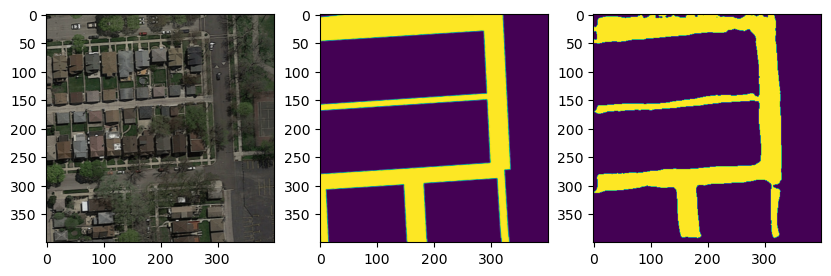

In [60]:
# model.load_state_dict(torch.load("models/2023_12_04_02:10:09.pt")).to(device)
# for idx in range(dataset.__len__()):
for idx in range(1):
    img, gt = dataset[idx]
    ax, fig = plt.subplots(1,3, figsize=(10,10))
    fig[0].imshow(img.permute(1,2,0))
    fig[0].set_title("Input Image")

    fig[1].imshow(gt.squeeze(0))
    fig[1].set_title("Ground Truth")

    pred = model(img.unsqueeze(0).to(device))[0].permute(1,2,0).detach()
    pred_np = pred.cpu().numpy().squeeze(2)
    pred_np = pred_np > 0.5
    fig[2].imshow(pred_np)
    fig[2].set_title("Predicted Mask")
    plt.show()

## 3) Visualize Effects of Postprocessing

In [4]:
for idx in range(1):
    img, gt = dataset[idx]
    ax, fig = plt.subplots(1,4, figsize=(10,6))
    fig[0].imshow(gt.permute(1,2,0))
    fig[0].set_title("Ground Truth")
    
    pred = model(img.unsqueeze(0).to(device))[0].permute(1,2,0).detach()
    pred_np = pred.cpu().numpy().squeeze(2)
    fig[1].imshow(pred_np>0.5)
    fig[1].set_title("Original Predicted Mask")


    pred_np_processed2 = fill_gaps_with_hough_transform_and_interpolation(pred_np)
    fig[2].imshow(pred_np_processed2)
    fig[2].set_title("1st Postprocessing Mask")

    fig[3].imshow(morphological_postprocessing( connected_components_postprocessing(pred_np_processed2) ))
    fig[3].set_title("2nd Postprocessing Mask")
    plt.show()

NameError: name 'dataset' is not defined

## 4) Generating Test Masks

In [6]:
class testDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, f"test_{idx+1}", f"test_{idx+1}.png")
        image = mpimg.imread(img_name)

        if self.transform:
            image = self.transform(image)

        return image

In [170]:
# load the test data
transform = transforms.Compose([
    transforms.ToTensor(),  
])

# check if the test_set_masks folder exists, if not create it
if not os.path.exists("data/test_set_masks"):
    os.makedirs("data/test_set_masks")
else:
    # delete the contents of the test_set_masks folder
    for file in os.listdir("data/test_set_masks"):
        os.remove(os.path.join("data/test_set_masks", file))

# load the test dataset
test_dataset = testDataset("data/test_set_images", transform=transform)

# run the test data through the model and save the output masks
for i in range(len(test_dataset)-1):
    image = test_dataset[i].unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
    output = output > 0.5
    output = output.squeeze().cpu().numpy()
    output = morphological_postprocessing( connected_components_postprocessing(fill_gaps_with_hough_transform_and_interpolation(output) ))

    plt.imsave(f"data/test_set_masks/test_{i+1}_mask.png", output, cmap='gray')